# Anderson model of localization

## parameter choices

In [1]:
myseed= 111111
width= 20
nimages= 100
img_sizeX= 100
img_sizeY= img_sizeX

validation_split= 0.1
batch_size= 64
myepochs= num_epochs =10
mylr= 0.01
mywd= 1e-6

dataname='L'+str(width)+'-'+str(nimages)+'-s'+str(img_sizeX)

#datapath = '/run/media/phsht/DisQSTransport/'+'ML-Anderson3D/Images/'+dataname # SC-RTP ExternalDataDrive
datapath = '/storage/disqs/'+'ML-Anderson3D/ImagesTest/'+dataname # SC-RTP
#datapath = '/mnt/DataDrive/'+'ML-Data/Anderson/Images/'+dataname # Ubuntu home RAR
    
print(dataname,"\n",datapath)

method='Keras-OhtsukiCNN-'+str(myseed)+'-e'+str(num_epochs) #+'-bs'+str(batch_size)
modelname = 'Model_'+method+'_'+dataname+'.pth'
historyname = 'History_'+method+'_'+dataname+'.pkl'
print(method,"\n",modelname,"\n",historyname)

savepath = './'+dataname+'/'
import os
try:
    os.mkdir(savepath)
except FileExistsError:
    pass

modelpath = savepath+modelname
historypath = savepath+historyname
print(savepath,modelpath,historypath)

L20-100-s100 
 /storage/disqs/ML-Anderson3D/ImagesTest/L20-100-s100
Keras-OhtsukiCNN-111111-e10 
 Model_Keras-OhtsukiCNN-111111-e10_L20-100-s100.pth 
 History_Keras-OhtsukiCNN-111111-e10_L20-100-s100.pkl
./L20-100-s100/ ./L20-100-s100/Model_Keras-OhtsukiCNN-111111-e10_L20-100-s100.pth ./L20-100-s100/History_Keras-OhtsukiCNN-111111-e10_L20-100-s100.pkl


## initializations

In [2]:
#standard notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#standard libraries
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

import random as rn
import os
import matplotlib.pyplot as plt
sys.path.insert(0,'../../../../PyCode/')
#np.random.seed(1337) # for reproducibility
#np.random.seed(2000) 

In [4]:
#machine learning libraries
import tensorflow as tf 
import keras
print("tensorflow: ",tf.__version__, ", keras: ", keras.__version__)

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
print("sklearn: ", sklearn.__version__)

Using TensorFlow backend.


tensorflow:  2.1.0 , keras:  2.3.1
sklearn:  0.21.3


In [5]:
#special subroutines
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, Flatten
from keras.layers import Dropout
from keras import optimizers
from keras.models import load_model

# from tensorflow.keras.layers import Dense, Conv2D
# from tensorflow.keras.layers import Conv1D, MaxPooling2D
# from tensorflow.keras.layers import AveragePooling2D, Flatten
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.models import Sequential


# from tensorflow.keras.utils import to_categorical

# import numpy

## starting the main code

In [6]:
np.random.seed(myseed) # necessary for starting Numpy generated random numbers in a well-defined initial state.
rn.seed(myseed+1) # necessary for starting core Python generated random numbers in a well-defined state.

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

os.environ['PYTHONHASHSEED'] = '0'

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v2.random.set_seed(myseed+3)
#tf.set_random_seed(1234)

#sess = tf.compat.v2.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

## reading the images

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,validation_split=validation_split)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
training_set = train_datagen.flow_from_directory(datapath,
                                                 subset='training',
                                                 target_size = (img_sizeX,img_sizeY),
                                                 batch_size = batch_size, 
                                                 class_mode='categorical',
                                                shuffle=True,seed=myseed)

validation_set= train_datagen.flow_from_directory(datapath, 
                                              subset='validation', 
                                              target_size = (img_sizeX,img_sizeY),
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                                 shuffle=False,seed=myseed)

# test_set = test_datagen.flow_from_directory('data-keras-L20-100/test_set',
#                                             target_size = (171, 171),
#                                             batch_size = batch_size,
#                                             class_mode='categorical',
#                                            shuffle=False)

Found 1530 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


In [9]:
# X_train, X_labels = next(training_set)
# Y_train, Y_labels = next(validation_set)
# len(X_train),len(X_labels),len(Y_train),len(Y_labels)

In [10]:
num_of_train_samples = training_set.samples
num_of_test_samples = validation_set.samples
num_classes = len(validation_set.class_indices)

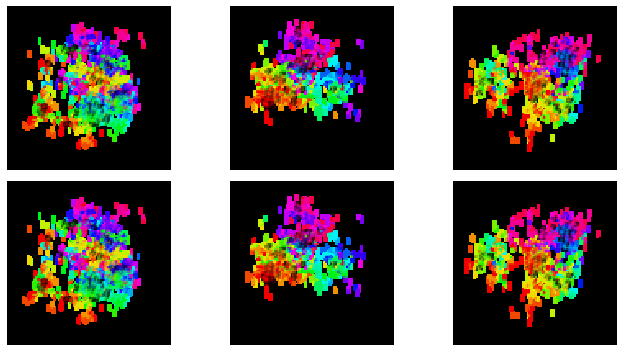

In [11]:
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in validation_set:
        plt.imshow(x[0],cmap='hsv')
        #plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

## building the CNN

In [12]:
def create_CNN():
    # instantiate model
    model=Sequential()

    model.add(Conv2D(16, kernel_size=(5,5),input_shape=(img_sizeX, img_sizeY, 3),
                     activation = 'relu',  padding='valid'))
    model.add(Conv2D(16, kernel_size=(5,5),activation = 'relu',padding='same'))
    
    model.add(MaxPooling2D(pool_size =(2, 2), padding='same'))

    model.add(Dropout(0.5))
               
    model.add(Conv2D(32,kernel_size=(3,3), activation = 'relu', padding='valid'))  
    model.add(Conv2D(32,kernel_size=(3,3), activation = 'relu', padding='same')) 
                 
    model.add(MaxPooling2D(pool_size =(2, 2),padding='same')) 
    
    model.add(Dropout(0.5))

    model.add(Conv2D(64, kernel_size=(5,5), activation = 'relu',  padding='valid'))
    model.add(Conv2D(64, kernel_size=(5,5),activation = 'relu',padding='same'))
    model.add(MaxPooling2D(pool_size =(2, 2),padding='same'))
                  
    model.add(Dropout(0.5))

    model.add(Flatten())
                             
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = num_classes, activation = 'softmax')) 
    
    return model

print('CNN architecture (Ohtsuki) created successfully!')

CNN architecture (Ohtsuki) created successfully!


In [13]:
# Choose the Optimizer and the Cost Function

opt = optimizers.SGD(lr=mylr, decay=mywd)
#opt = keras.optimizers.Adam(lr=mylr, decay=mywd)

def compile_model(optimizer=opt):
    # create the mode
    model=create_CNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy','categorical_crossentropy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


In [14]:
# opt = optimizers.SGD(lr=mylr, decay=mywd)
# model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# create the deep neural net
model = compile_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)       

## learning the images

In [15]:
# train DNN and store training info in history
history = model.fit_generator(training_set,
                         steps_per_epoch = training_set.samples // batch_size,
                         epochs = myepochs,
                         validation_data = validation_set,
                         validation_steps = validation_set.samples // batch_size)

Epoch 1/10
23/23 [==============================] - 217s 9s/step - loss: 2.8954 - accuracy: 0.0464 - categorical_crossentropy: 2.8957 - val_loss: 40.0915 - val_accuracy: 0.0156 - val_categorical_crossentropy: 25.2833
Epoch 2/10
23/23 [==============================] - 21s 912ms/step - loss: 84708687.4044 - accuracy: 0.0505 - categorical_crossentropy: 85040880.0000 - val_loss: 2.8375 - val_accuracy: 0.0943 - val_categorical_crossentropy: 2.8350
Epoch 3/10
23/23 [==============================] - 1s 42ms/step - loss: 530380479978206330880.0000 - accuracy: 0.0573 - categorical_crossentropy: 532460408022153297920.0000 - val_loss: 2.8323 - val_accuracy: 0.0943 - val_categorical_crossentropy: 2.8303
Epoch 4/10
23/23 [==============================] - 1s 35ms/step - loss: 154025582454828209629892142958641152.0000 - accuracy: 0.0553 - categorical_crossentropy: 154629604779089707681319727870771200.0000 - val_loss: 2.8329 - val_accuracy: 0.0781 - val_categorical_crossentropy: 2.8340
Epoch 5/10
2

In [16]:
# tf.keras.models.save_model(history,'Anderson_Ohtsuki_model_L20_500_keras_SGD_0_01_good_input_size.h5') 
model.save(modelpath) 

import pickle 
f=open(historypath,"wb")
pickle.dump(history,f)
f.close()

## testing the quality of the learned model

In [17]:
#history = load_model(modelpath)

### training history

3/3 [==============================] - 0s 31ms/step

Test loss: nan
Test accuracy: 0.05882352963089943


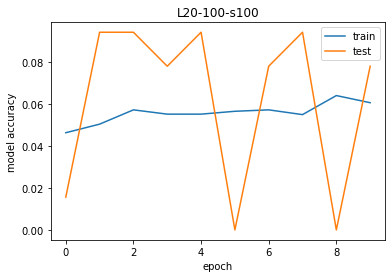

In [18]:
# evaluate model
score=model.evaluate(validation_set,verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
fig=plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(savepath+'/'+method+'_'+dataname+'_accuracy'+'.png')

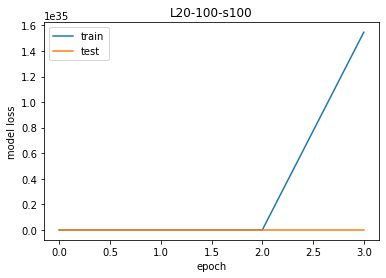

In [19]:
# summarize history for loss
fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(savepath+'/'+method+'_'+dataname+'_loss'+'.png')
#print(datapath+'/'+surname+dataname+'_loss'+'.png')

### confusion matrix

In [20]:
validation_set.reset()
label=validation_set.class_indices.keys()

#Confusion Matrix 
Y_pred = model.predict_generator(validation_set, num_of_test_samples // batch_size+1, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

#basic confusion matrix
confusion_matrix(validation_set.classes, y_pred)

3/3 [==============================] - 0s 40ms/step


array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  

In [21]:
# sys.path.insert(0,'/storage/disqs/ML-Anderson/ML-Anderson/PyCode/')
# from plot_confusion_matrix import *

In [22]:
# os.chdir('/home/physics/phsht/Desktop/CSCCloud/Projects/ML-Anderson3D/ImageBased/Keras/3D/SCRTP-RAR/')

/storage/disqs/ML-Anderson3D/ML-Anderson3D/ImageBased/Keras/3D/SCRTP-RAR


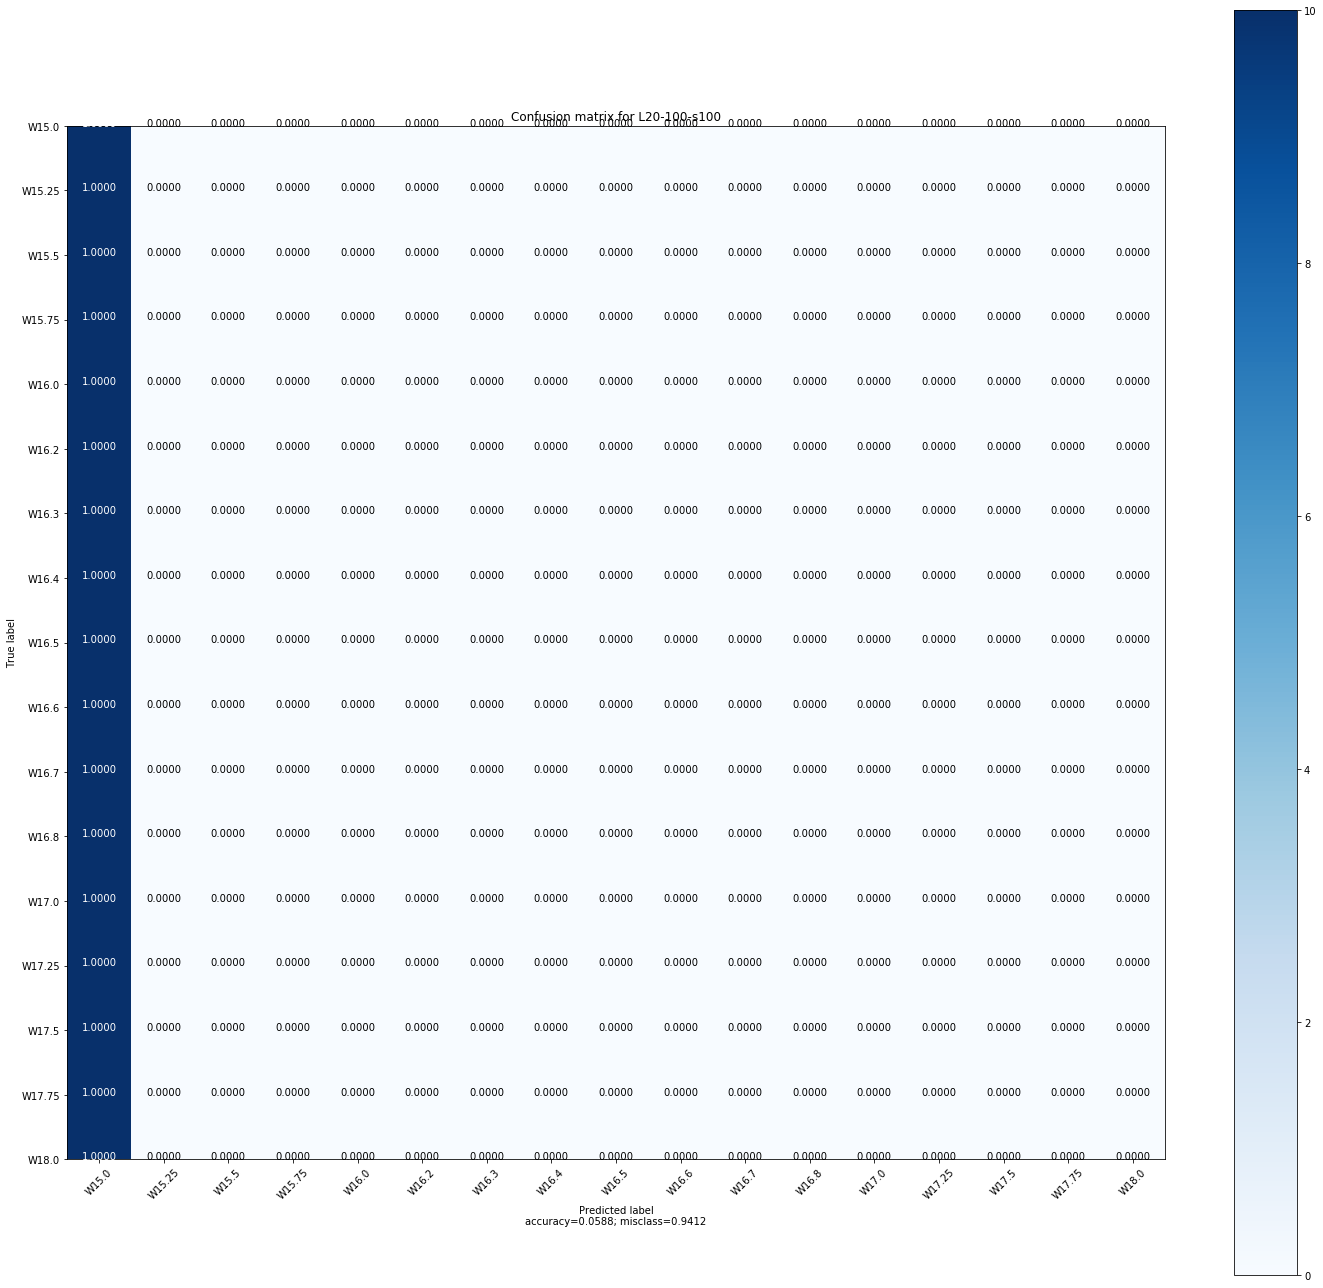

None


In [24]:
print(os.getcwd())
#os.chdir('../../../../PyCode/')
sys.path.insert(0,'../../../../PyCode/')
from plot_confusion_matrix import *

print(plot_confusion_matrix(confusion_matrix(validation_set.classes, y_pred),
                          label,savepath+'/'+method+'_'+dataname+'_cfm'+'.png',
                          title='Confusion matrix for '+dataname,
                          cmap=None,
                          normalize=True))
#os.chdir('../src/')

In [25]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>